# Projeto SERS – Gestão Sustentável de Energia em um Escritório de TI

Este notebook faz parte da GS da disciplina **Soluções em Energias Renováveis e Sustentáveis (SERS)**.

Objetivo:
- Simular dados de consumo de energia em um pequeno escritório de TI;
- Analisar desperdícios de energia ao longo do mês;
- Simular ajustes de uso (boas práticas e automação simples);
- Simular a adoção de um sistema de energia solar fotovoltaica;
- Comparar cenários de consumo antes e depois das melhorias.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline


## 1. Simulação dos dados de consumo de energia

Vamos simular o consumo de energia de um escritório de TI durante um mês completo (30 dias),
com leituras **de hora em hora**. O objetivo não é obter valores reais exatos, mas sim um
conjunto de dados plausível para análise.


In [2]:
#garantir pasta de dados
os.makedirs('dados', exist_ok=True)

#criar intervalo de datas (30 dias, de hora em hora)
datas = pd.date_range('2025-09-01', '2025-09-30 23:00', freq='H')

df = pd.DataFrame({'data_hora': datas})
df['data'] = df['data_hora'].dt.date
df['hora'] = df['data_hora'].dt.hour
df['dia_da_semana'] = df['data_hora'].dt.dayofweek  # 0=segunda, 6=domingo
df['eh_dia_util'] = df['dia_da_semana'] < 5
df['em_horario_trabalho'] = df['eh_dia_util'] & df['hora'].between(8, 18)

np.random.seed(42)

def simular_consumo(linha):
    hora = linha['hora']
    eh_dia_util = linha['eh_dia_util']
    #definimos um consumo base em kWh por hora, de forma simplificada
    if eh_dia_util:
        if 8 <= hora <= 18:
            base = np.random.uniform(10, 15)  #horário de expediente, muitos equipamentos ligados
        else:
            base = np.random.uniform(2, 4)    #fora do expediente, standby e alguns equipamentos esquecidos
    else:
        #fim de semana
        if 10 <= hora <= 16:
            base = np.random.uniform(4, 7)    #uso eventual do escritório
        else:
            base = np.random.uniform(1, 3)    #quase tudo desligado
    #pequena variação aleatória
    ruido = np.random.normal(0, 0.3)
    return max(base + ruido, 0.1)

df['kwh'] = df.apply(simular_consumo, axis=1).round(2)

#salvar csv
caminho_csv = os.path.join('dados', 'consumo_energia.csv')
df.to_csv(caminho_csv, index=False)
caminho_csv


/tmp/ipython-input-3645113416.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datas = pd.date_range('2025-09-01', '2025-09-30 23:00', freq='H')


'dados/consumo_energia.csv'

In [3]:
#visualizar as primeiras linhas do dataset simulado
df.head()


,data_hora,data,hora,dia_da_semana,eh_dia_util,em_horario_trabalho,kwh
0,2025-09-01 00:00:00,2025-09-01,0,0,True,False,2.42
1,2025-09-01 01:00:00,2025-09-01,1,0,True,False,2.41
2,2025-09-01 02:00:00,2025-09-01,2,0,True,False,2.20
3,2025-09-01 03:00:00,2025-09-01,3,0,True,False,3.72
4,2025-09-01 04:00:00,2025-09-01,4,0,True,False,1.87


## 2. Análise exploratória do consumo

Nesta etapa vamos observar:
- Consumo total diário (kWh por dia);
- Consumo médio por hora do dia (para identificar picos de uso ao longo do expediente);
- Distribuição entre consumo **em horário de trabalho** e **fora do expediente**.


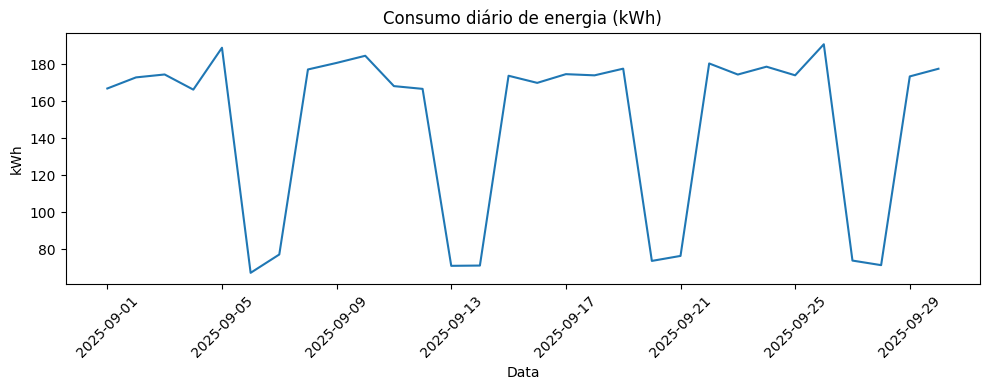

,kwh
count,30.000000
mean,148.272333
std,46.681109
min,67.260000
25%,99.447500
50%,173.600000
75%,177.465000
max,190.800000


In [4]:
#consumo total por dia
consumo_diario = df.groupby('data')['kwh'].sum()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(consumo_diario.index, consumo_diario.values)
ax.set_title('Consumo diário de energia (kWh)')
ax.set_xlabel('Data')
ax.set_ylabel('kWh')
ax.xaxis.set_major_locator(MaxNLocator(10))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

consumo_diario.describe()


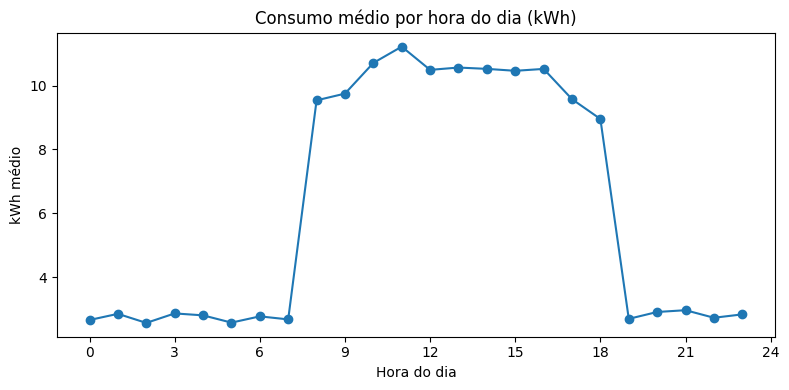

,kwh
hora,
0,2.663000
1,2.855667
2,2.571667
3,2.868667
4,2.808333
5,2.580667
6,2.776333
7,2.681667
8,9.538667


In [5]:
#consumo médio por hora do dia
consumo_por_hora = df.groupby('hora')['kwh'].mean()

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(consumo_por_hora.index, consumo_por_hora.values, marker='o')
ax.set_title('Consumo médio por hora do dia (kWh)')
ax.set_xlabel('Hora do dia')
ax.set_ylabel('kWh médio')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

consumo_por_hora


In [6]:
#proporção de consumo em horário de trabalho x fora
total_consumo = df['kwh'].sum()
consumo_trabalho = df.loc[df['em_horario_trabalho'], 'kwh'].sum()
consumo_fora = df.loc[~df['em_horario_trabalho'], 'kwh'].sum()

propor_trabalho = consumo_trabalho / total_consumo * 100
propor_fora = consumo_fora / total_consumo * 100

print(f"Consumo total no mês: {total_consumo:.2f} kWh")
print(f"Consumo em horário de trabalho: {consumo_trabalho:.2f} kWh ({propor_trabalho:.1f}%)")
print(f"Consumo fora do expediente: {consumo_fora:.2f} kWh ({propor_fora:.1f}%)")


Consumo total no mês: 4448.17 kWh
Consumo em horário de trabalho: 2998.13 kWh (67.4%)
Consumo fora do expediente: 1450.04 kWh (32.6%)


## 3. Simulação de ajustes de uso (boas práticas e automação)

Vamos supor que a empresa adote boas práticas, como:
- Desligamento automático de computadores após 30 minutos de inatividade;
- Sensores de presença para iluminação em áreas de circulação;
- Programação do ar-condicionado para desligar ao fim do expediente.

Na simulação, vamos considerar que essas ações reduzem em **50%** o consumo
fora do horário de trabalho (madrugada, início da manhã e noite).


In [7]:
#criar coluna com consumo ajustado
df['kwh_ajustado'] = df['kwh']

#reduzir 50% do consumo fora do expediente
mascara_fora = ~df['em_horario_trabalho']
df.loc[mascara_fora, 'kwh_ajustado'] = df.loc[mascara_fora, 'kwh'] * 0.5

consumo_total_original = df['kwh'].sum()
consumo_total_ajustado = df['kwh_ajustado'].sum()

economia_kwh = consumo_total_original - consumo_total_ajustado
economia_percentual = economia_kwh / consumo_total_original * 100

print(f"Consumo original: {consumo_total_original:.2f} kWh")
print(f"Consumo após ajustes de uso: {consumo_total_ajustado:.2f} kWh")
print(f"Economia estimada: {economia_kwh:.2f} kWh ({economia_percentual:.1f}%)")


Consumo original: 4448.17 kWh
Consumo após ajustes de uso: 3723.15 kWh
Economia estimada: 725.02 kWh (16.3%)


## 4. Simulação de sistema de energia solar fotovoltaica

Agora vamos simular a instalação de um sistema fotovoltaico capaz de gerar uma
fração do consumo mensal do escritório. Para simplificar, vamos considerar que
o sistema gera **35%** do consumo original do mês (em kWh).

Essa geração será usada para compensar o consumo em horário diurno, reduzindo
a energia que precisa ser comprada da concessionária.


In [8]:
fator_solar = 0.35  #35% do consumo original
geracao_solar_mensal = consumo_total_original * fator_solar

consumo_rede_apenas_solar = consumo_total_original - geracao_solar_mensal
consumo_rede_ajustes_e_solar = consumo_total_ajustado - geracao_solar_mensal
consumo_rede_ajustes_e_solar = max(consumo_rede_ajustes_e_solar, 0)

print(f"Geração do sistema solar (mês): {geracao_solar_mensal:.2f} kWh")
print(f"Consumo da rede (antes das melhorias): {consumo_rede_apenas_solar:.2f} kWh")
print(f"Consumo da rede (ajustes + solar): {consumo_rede_ajustes_e_solar:.2f} kWh")


Geração do sistema solar (mês): 1556.86 kWh
Consumo da rede (antes das melhorias): 2891.31 kWh
Consumo da rede (ajustes + solar): 2166.29 kWh


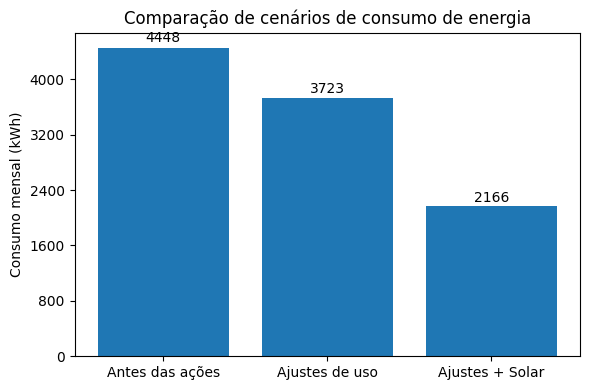

In [9]:
#comparação dos cenários em gráfico de barras
cenarios = ['Antes das ações', 'Ajustes de uso', 'Ajustes + Solar']
valores = [consumo_total_original, consumo_total_ajustado, consumo_rede_ajustes_e_solar]

fig, ax = plt.subplots(figsize=(6, 4))
barras = ax.bar(cenarios, valores)
ax.set_ylabel('Consumo mensal (kWh)')
ax.set_title('Comparação de cenários de consumo de energia')
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))

for barra in barras:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, altura * 1.01,
            f"{altura:.0f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 5. Conclusões do notebook

Neste notebook, construímos um **mini-projeto de sustentabilidade energética** para um
escritório de TI, incluindo:

- Simulação de dados de consumo horário em um mês;
- Análise exploratória de padrões de uso e identificação de desperdícios;
- Simulação de boas práticas e automação para reduzir consumo fora do expediente;
- Simulação de um sistema fotovoltaico cobrindo parte do consumo mensal;
- Comparação visual dos cenários de consumo antes e depois das ações.

O notebook pode ser facilmente adaptado para receber dados reais de um escritório ou de uma
residência, bastando substituir o arquivo CSV gerado pela simulação por medições reais de
consumo (por exemplo, de uma planilha de contas de energia ou de um medidor inteligente).
